In [2]:
import numpy as np
from numpy import linalg as LA
import cv2
import matplotlib.pyplot as plt
import random
import sys
%matplotlib inline

# Question 1)

In [ ]:
img1 = cv2.imread('GB1.jpg', 0) 
img2 = cv2.imread('GB2.jpg', 0)

img1_ori = cv2.imread('GB1.jpg') 
img2_ori = cv2.imread('GB2.jpg')

img1_ori = cv2.cvtColor(img1_ori, cv2.COLOR_BGR2RGB)
img2_ori = cv2.cvtColor(img2_ori, cv2.COLOR_BGR2RGB)

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher( crossCheck=True)
matches = bf.match(des1,des2)

print "img1 has {} keypoints".format(len(des1))
print "img2 has {} keypoints".format(len(des2))
print "two images has {} matches\n".format(len(matches))

# Calculate homography with RANSAC
pts_src = np.float32([kp1[a.queryIdx].pt for a in matches])
pts_dst = np.float32([kp2[b.trainIdx].pt for b in matches])

H, inliners = cv2.findHomography(pts_src, pts_dst, cv2.RANSAC, 1.0)
print H
print "\n {} inliners".format(len([a for a in inliners if a>0]))

# Translate
h1,w1 = img1.shape[:2]
h2,w2 = img2.shape[:2]
pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
pts2_ = cv2.perspectiveTransform(pts2, H)
pts = np.concatenate((pts1, pts2_), axis=0)
[xmin, ymin] = np.int32(pts.min(axis=0).ravel())
[xmax, ymax] = np.int32(pts.max(axis=0).ravel())
t = [-xmin,-ymin]
Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) 
    
# Creating pano
img_dst = cv2.warpPerspective(img1_ori, Ht.dot(H), (xmax-xmin, ymax-ymin))
img_dst[t[1]:h1+t[1],t[0]:w1+t[0]] = img2_ori

# Didplay results
plt.figure(figsize=(15,20))
plt.subplot(121), plt.imshow(img1_ori), plt.title('img1')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img2_ori), plt.title('img2')
plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,20))
plt.imshow(img_dst), plt.title('Pano stitches')
plt.xticks([]), plt.yticks([])
# plt.savefig('output_img/q1b_output.jpg')
plt.show()

# Question2

## K-Means

[]
[21, 35, 34]
[[21, 35, 34]]
[158, 180, 186]
[[21, 35, 34], [158, 180, 186]]
[50, 61, 52]
[[21, 35, 34], [158, 180, 186], [50, 61, 52]]
[107, 115, 116]
[[21, 35, 34], [158, 180, 186], [50, 61, 52], [107, 115, 116]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
generating cluster photo ...


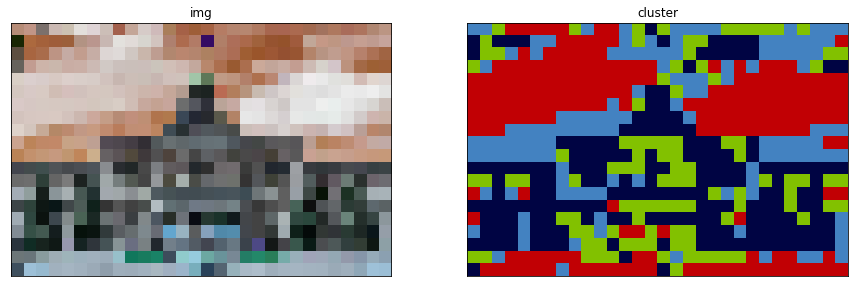

In [265]:
img_full_res = cv2.imread('GB1.jpg', 0) 
img = cv2.resize(img_full_res, (600,480))
img_ori_full_res = cv2.imread('GB1.jpg') 
img_ori = cv2.resize(img_ori_full_res, (400,320))
img_test = cv2.imread('test.png') 

def generate_random_centroid(img, num_of_cluster):
    cluster_centers = []
    for index in xrange(num_of_cluster):
        while True:
            random_center = random.choice(img)
            if type(random_center) == np.ndarray:
                random_center = map(lambda x: int(x), random_center)
            print cluster_centers
            print random_center
            if random_center not in cluster_centers:
                cluster_centers.append(random_center)
                break
    return cluster_centers

def reassign_cluster_for_all_points(img, cluster_centroids, clusters):
    new_clusters = [[] for _ in range(len(clusters))]
    for point_index in xrange(len(img)):
        point = img[point_index]
        min_index = 0
        min_distance = sys.maxint
        for centroid_index in xrange(len(cluster_centroids)):
            if type(point) == np.uint8 or type(point) == int:                
                point = int(point)
            else:
                point = map(lambda x: int(x), point)
 
            cluster_center = cluster_centroids[centroid_index]
            if type(cluster_center) == np.uint8 or type(point) == int:
                cluster_center = int(cluster_center)
            else:
                cluster_center = map(lambda x: int(x), cluster_center)
            temp_distance = np.sum(np.sqrt(abs(np.array(point)**2-np.array(cluster_center)**2)))
            if temp_distance < min_distance:
                min_index = centroid_index
                min_distance = temp_distance
        new_clusters[min_index].append(point_index)
    return (new_clusters, not np.array_equal(new_clusters, clusters))

def recalculate_cluster_centroids(img, clusters):
    cluster_centroids = [[] for _ in range(len(clusters))]
    for i in xrange(len(clusters)):
        cluster = clusters[i]
        cluster = map(lambda x: img[x], cluster)
        cluster_centroids[i] = np.average(np.array(cluster),axis=0)
    return cluster_centroids



def perform_k_means(img, num_of_cluster):
#     img_bk = np.copy(img)
    size = img.shape
    try:
        img.resize((size[0]*size[1], 3))
    except:
        img = img.flatten()
        
    cluster_centroids = generate_random_centroid(img, num_of_cluster)
    clusters = [[] for _ in range(num_of_cluster)]
    
    print cluster_centroids
    print "==================================="
    
    count = 0


    while True:
        print count
        count += 1
        clusters, modified = reassign_cluster_for_all_points(img, cluster_centroids, clusters)
        if not modified:
            break
        cluster_centroids = recalculate_cluster_centroids(img, clusters)

    print "generating cluster photo ..."
    img = img.reshape(size)
    paint_img = np.zeros(img.shape)
    
    color = np.arange(0,255,255/(num_of_cluster))
    if (type(img[0][0]) != np.uint8):
        color_stack = []
        for i in range(3):
            color_stack.append(np.roll(color, i))
        color = np.stack(color_stack, axis=1)

        
    color_index = 0
    for cluster in clusters:
        color_cluster = color[color_index]
        color_index += 1
        for pixel_index in cluster:
            row = pixel_index/img.shape[1]
            col = pixel_index%img.shape[1]
            paint_img[row][col] = color_cluster
    return paint_img

    
    
paint_img = perform_k_means(np.copy(img_test), 4)
        
plt.figure(figsize=(15,20))
plt.subplot(121), plt.imshow(img_test), plt.title('img')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(paint_img), plt.title('cluster')
plt.xticks([]), plt.yticks([])
plt.show()

## Mean-Shift

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
generating cluster photo ...


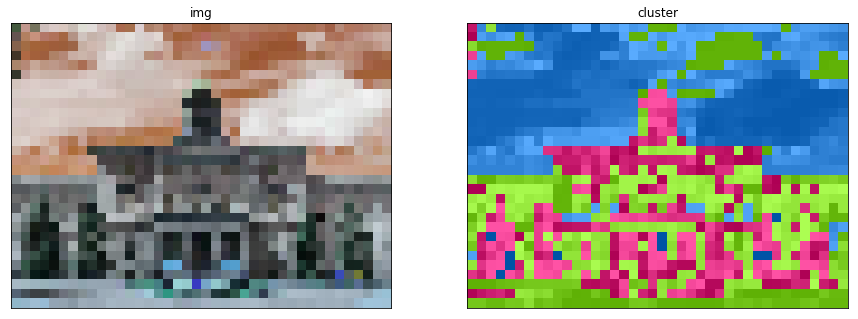

In [345]:
img_full_res = cv2.imread('GB1.jpg', 0) 
img = cv2.resize(img_full_res, (300,240))
img_ori_full_res = cv2.imread('GB1.jpg') 
img_ori = cv2.resize(img_ori_full_res, (400,320))
img_test = cv2.resize(cv2.imread('test.png'), (40,30))

def assign_clusters(img, cluster_centroids):
    
    clusters = [[] for _ in range(len(cluster_centroids))]
#     print img
    for pixel_index in xrange(len(img)):
        min_dist = sys.maxint
        min_index = 0
        pixel = img[pixel_index]
        
        for centroid_index in xrange(len(cluster_centroids)):
            centroid = cluster_centroids[centroid_index]
            temp_dist = np.linalg.norm(pixel-centroid)
            if temp_dist < min_dist:
                min_index = centroid_index
                min_dist = temp_dist

        clusters[min_index].append(pixel_index)
        
    return clusters

def perform_mean_shift(img, radius):
    size = img.shape
    try:
        img.resize((size[0]*size[1], 3))
    except:
        img = img.flatten()
    img.astype(int)
#     img = map(lambda x: tuple(x), img)
    cluster_centroids = np.copy(img)
    count = 0

    while True:
        print count
        count += 1
        new_centroids = []
        for centroid in cluster_centroids:
            cluster = filter(lambda x: np.linalg.norm(x-centroid)<radius, img)
            new_centroid = np.average(cluster, axis=0)
            new_centroids.append(tuple(new_centroid))
            
        new_centroids = sorted(list(set(new_centroids)))
        modified = np.array_equal(cluster_centroids, new_centroids)
        
        cluster_centroids = new_centroids
        new_centroids = []
        
        if modified:
            break

    clusters = assign_clusters(img, cluster_centroids)
    
    print "generating cluster photo ..."
    img = img.reshape(size)
    paint_img = np.zeros(img.shape)
    
    color = np.arange(0,255,255/(len(cluster_centroids)))
    if (type(img[0][0]) != np.uint8):
        color_stack = []
        for i in range(3):
            color_stack.append(np.roll(color, i*len(cluster_centroids)/3))
        color = np.stack(color_stack, axis=1)
#     print color  
    color_index = 0
    for cluster in clusters:
        color_cluster = color[color_index]
        color_index += 1
#         print color_cluster
        for pixel_index in cluster:
            row = pixel_index/img.shape[1]
            col = pixel_index%img.shape[1]
            paint_img[row][col] = color_cluster
    return paint_img

paint_img = perform_mean_shift(np.copy(img_test), 10)

plt.figure(figsize=(15,20))
plt.subplot(121), plt.imshow(img_test), plt.title('img')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(paint_img), plt.title('cluster')
plt.xticks([]), plt.yticks([])
plt.show()

## Gaussian Mixture Models (EM)

In [212]:


def binary_search(number_list, target):
    if number_list == None:
        return -1
    start = 0
    end = len(number_list)-1
    while start <= end:
        middle = (end-start)/2 + start
        if number_list[middle] == target:
            return middle
        elif target < number_list[middle]:
            end = middle - 1
        else:
            start = middle + 1
            
    return -1

print binary_search([1, 2], 3)

-1
